In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

In [21]:
data1 = pd.read_csv('smallfrac.csv')

In [21]:
data1=data1.drop(['Unnamed: 0'],axis=1)

In [4]:
def GetRSqr(testY,pred):
    
    upperSum=0
    lowerSum=0
    for i in range(len(testY)):
        upperSum+=(testY[i]-pred[i])**2
        lowerSum+=(testY[i])**2
        
    return 1-(upperSum/lowerSum)

result R square for batch 0 :  -0.003968870339267516 best combine: (3, 5)
result R square for batch 1 :  0.010597218731844937 best combine: (3, 5)
result R square for batch 2 :  -0.006260045522992419 best combine: (3, 5)
result R square for batch 3 :  -0.021422493783168184 best combine: (3, 5)
result R square for batch 4 :  0.019109129731599173 best combine: (3, 5)
result R square for batch 5 :  0.0208604120095508 best combine: (3, 5)
result R square for batch 6 :  0.013694307375009873 best combine: (3, 5)
result R square for batch 7 :  -0.03725427696158734 best combine: (5, 10)
result R square for batch 8 :  0.023120044739249113 best combine: (3, 10)
result R square for batch 9 :  0.005254940532155805 best combine: (3, 10)
result R square for batch 10 :  0.01078415772382757 best combine: (3, 10)
result R square for batch 11 :  0.0005672410529448113 best combine: (5, 5)
result R square for batch 12 :  0.009361607522247795 best combine: (5, 10)
result R square for batch 13 :  -0.0044819

Text(0.5, 0, 'Random Forest Feature Importance')

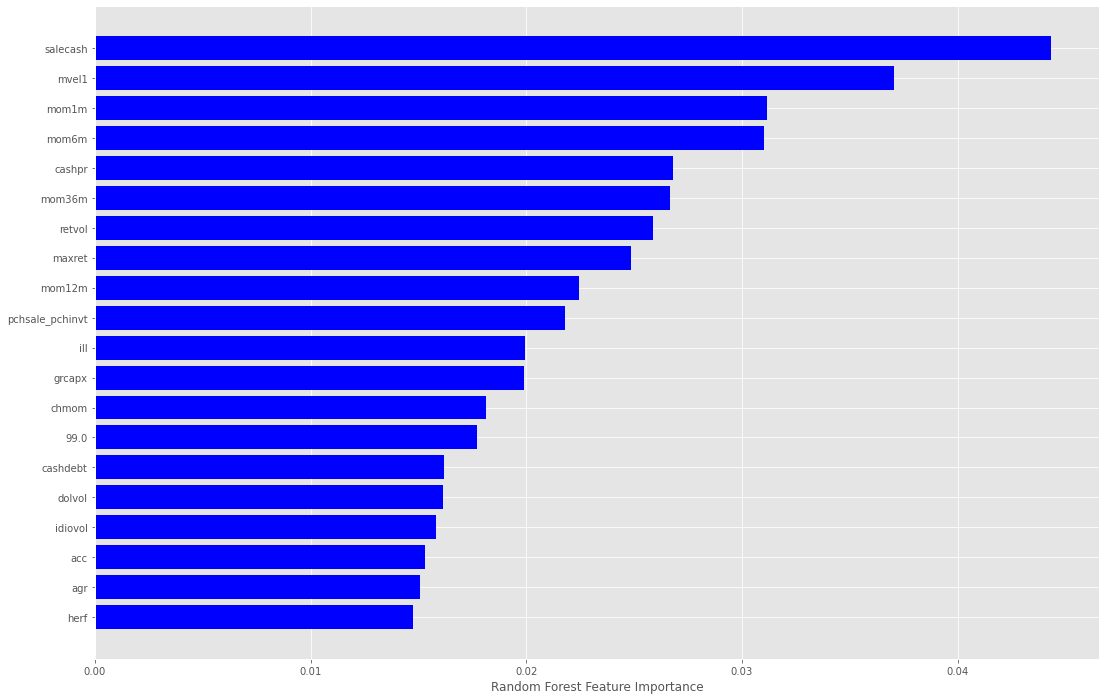

In [27]:
#存储每一个batch的r
r2RFList=[]


for i in range(0,30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data1['DATE'] >= trainingMaskStart) & (data1['DATE'] < trainingMaskEnd)
    trainingData = data1.loc[trainingMask]
    
    validationMask = (data1['DATE'] >= trainingMaskEnd) & (data1['DATE'] < validationMaskEnd)
    validationData = data1.loc[validationMask]
    
    testMask = (data1['DATE'] >= validationMaskEnd) & (data1['DATE'] < testMaskEnd)
    testData = data1.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用rf来对trainingData训练并fit validationData，
    #rf调节的地方是max_depth=3,5; max_features=3,5; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestRf = None
    bestCombine = None
    
    for depth in [3,5]:
        for feature in [5,10]:
            rf = RandomForestRegressor(n_estimators=300, random_state=72, max_depth=depth, max_features=feature)
            rf.fit(trainingData_x,trainingData_y)
    
            pred = rf.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestRf=rf
                bestCombine=(depth,feature)
        
    resultPred = bestRf.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    r2RFList.append(resultRSqr)
   

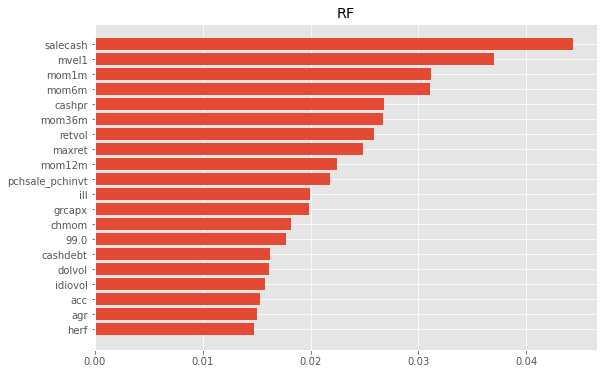

In [33]:

plt.figure(figsize=(9,6))
sorted_idx  = bestRf.feature_importances_.argsort()
top20_idx = sorted_idx[-20:]
plt.barh(testData_x.columns[top20_idx], bestRf.feature_importances_[top20_idx])
plt.title("RF")
plt.savefig('RF.png')

In [ ]:
import gc

gc.collect()
#存储每一个batch的r
r2GRBTList=[]


for i in range(0,30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data1['DATE'] >= trainingMaskStart) & (data1['DATE'] < trainingMaskEnd)
    trainingData = data1.loc[trainingMask]
    
    validationMask = (data1['DATE'] >= trainingMaskEnd) & (data1['DATE'] < validationMaskEnd)
    validationData = data1.loc[validationMask]
    
    testMask = (data1['DATE'] >= validationMaskEnd) & (data1['DATE'] < testMaskEnd)
    testData = data1.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用gbrt来对trainingData训练并fit validationData，
    #gbrt调节的地方是max_depth=1,2; learningrate = 0.01,  0.1; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestGRBT = None
    bestCombine = None
    
    for depth in [1,2]:
        for lr in [0.1,0.01]:
            grbt = GradientBoostingRegressor(n_estimators=50, random_state=72, max_depth=depth, learning_rate= lr)
            grbt.fit(trainingData_x,trainingData_y)
    
            pred = grbt.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestGRBT=grbt
                bestCombine=(depth, lr)
        
    resultPred = bestGRBT.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    r2GRBTList.append(resultRSqr)
    
print('average R2: ', sum(r2GRBTList)/len(r2GBRTList))

plt.figure(figsize=(18,12))
sorted_idx  = bestGRBT.feature_importances_.argsort()
top20_idx = sorted_idx[-20:]
plt.barh(testData_x.columns[top20_idx], bestGRBT.feature_importances_[top20_idx],color='blue')
plt.xlabel("GBRT Feature Importance")